# Training a Foreground Segmentation Tool with DINOv3

In this tutorial, we will train a linear foreground segmentation model using DINOv3 features.

### Setup

Let's start by loading some pre-requisites and checking the DINOv3 repository location:
- `local` if `DINOV3_LOCATION` environment variable was set to work with a local version of DINOv3 repository;
- `github` if the code should be loaded via torch hub.

In [ ]:
import os
import pickle
import tarfile
import urllib

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.functional as TF
from PIL import Image
from scipy import signal
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, precision_recall_curve
from tqdm import tqdm

### Model

Let's load the DINOv3 model. For this notebook, we will be using the ViT-L model, but if you have more or less hardware constraints, you can easily load any other DINOv3 model!

In [2]:
REPO_DIR = "../models/dinov3/"
model = torch.hub.load(REPO_DIR, 'dinov3_vitb16', source='local', weights="../model_weights/dinov3_vitb16.pth")


In [3]:
# Load the checkpoint file directly
checkpoint = torch.load("../model_weights/dinov3_vitb16.pth", map_location='cpu')

# Compare a key from both
key_to_check = 'blocks.0.attn.qkv.weight'  # Example key
if key_to_check in checkpoint and key_to_check in model.state_dict():
    weights_match = torch.allclose(checkpoint[key_to_check], model.state_dict()[key_to_check])
    print(f"Weights match for {key_to_check}: {weights_match}")

Weights match for blocks.0.attn.qkv.weight: True


### Data
Now that we have the model set up, let's load the training data. It consists of:

- images in `jpg` format:
```
https://dl.fbaipublicfiles.com/dinov3/notebooks/foreground_segmentation/foreground_segmentation_images.tar.gz
```

- and segmentation masks stored as alpha channels in `png` files:
```
https://dl.fbaipublicfiles.com/dinov3/notebooks/foreground_segmentation/foreground_segmentation_labels.tar.gz
```

In total, there are 9 training image / mask pairs.


In [5]:
IMAGES_PATH = "./images/foreground_segmentation_images.tar.gz"  # Update with your local path
LABELS_PATH = "./images/foreground_segmentation_labels.tar.gz"  # Update with your local path

# def load_images_from_local_tar(tar_path: str) -> list[Image.Image]:
#     images = []
#     with tarfile.open(tar_path, 'r:gz') as tar:
#         for member in tar.getmembers():
#             if member.isfile():  # Skip directories
#                 image_data = tar.extractfile(member)
#                 image = Image.open(image_data)
#                 images.append(image)
#     return images

def load_images_from_local_tar(tar_path: str) -> list[Image.Image]:
    images = []
    with tarfile.open(tar_path, 'r:gz') as tar:
        for member in tar.getmembers():
            if member.isfile():  # Skip directories
                image_data = tar.extractfile(member)
                # Load the image and force it into memory
                image = Image.open(image_data)
                image.load()  # ✅ This triggers actual data loading
                images.append(image)
    return images

images = load_images_from_local_tar(IMAGES_PATH)
labels = load_images_from_local_tar(LABELS_PATH)
n_images = len(images)
assert n_images == len(labels), f"{len(images)=}, {len(labels)=}"

print(f"Loaded {n_images} images and labels")

Loaded 9 images and labels


Let's, for example, visualize the first image / mask pair:

Showing image / mask at index 0:


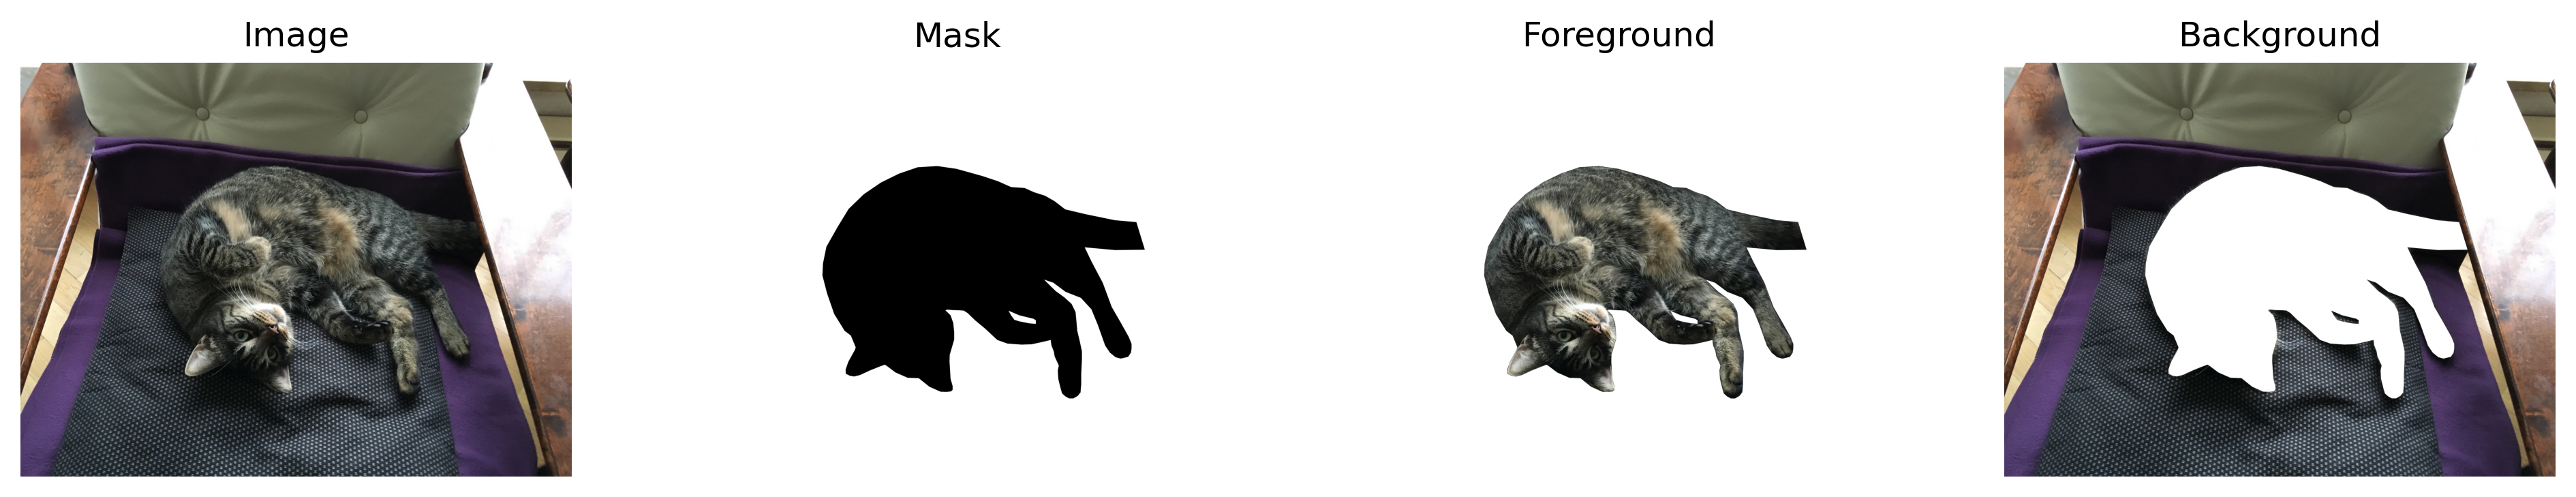

In [6]:
data_index = 0

print(f"Showing image / mask at index {data_index}:")

image = images[data_index]
mask = labels[data_index]
foreground = Image.composite(image, mask, mask)
mask_bg_np = np.copy(np.array(mask))
mask_bg_np[:, :, 3] = 255 - mask_bg_np[:, :, 3]
mask_bg = Image.fromarray(mask_bg_np)
background = Image.composite(image, mask_bg, mask_bg)

data_to_show = [image, mask, foreground, background]
data_labels = ["Image", "Mask", "Foreground", "Background"]

plt.figure(figsize=(16, 4), dpi=300)
for i in range(len(data_to_show)):
    plt.subplot(1, len(data_to_show), i + 1)
    plt.imshow(data_to_show[i])
    plt.axis('off')
    plt.title(data_labels[i], fontsize=12)
plt.show()

### Building Per-Patch Label Map

Since our models run with a patch size of 16, we have to quantize the ground truth to a 16x16 pixels grid. To achieve this, we define:
- the resize transform to resize an image such that it aligns well with the 16x16 grid;
- a uniform 16x16 conv layer as a [box blur filter](https://en.wikipedia.org/wiki/Box_blur) with stride equal to the patch size.

In [7]:
PATCH_SIZE = 16
IMAGE_SIZE = 768

# quantization filter for the given patch size
patch_quant_filter = torch.nn.Conv2d(1, 1, PATCH_SIZE, stride=PATCH_SIZE, bias=False)
patch_quant_filter.weight.data.fill_(1.0 / (PATCH_SIZE * PATCH_SIZE))

# image resize transform to dimensions divisible by patch size
def resize_transform(
    mask_image: Image,
    image_size: int = IMAGE_SIZE,
    patch_size: int = PATCH_SIZE,
) -> torch.Tensor:
    w, h = mask_image.size
    h_patches = int(image_size / patch_size)
    w_patches = int((w * image_size) / (h * patch_size))
    return TF.to_tensor(TF.resize(mask_image, (h_patches * patch_size, w_patches * patch_size)))

Let's, for example, visualize the first mask before and after quantization:

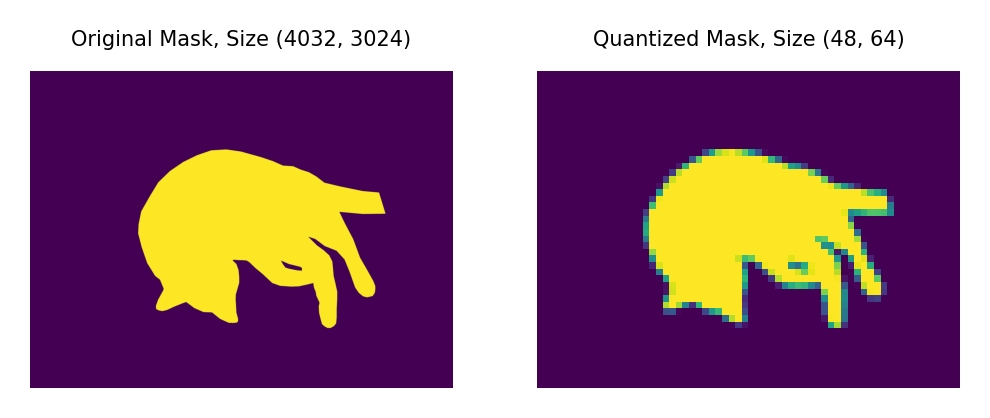

In [8]:
mask_0 = labels[0].split()[-1]
mask_0_resized = resize_transform(mask_0)
with torch.no_grad():
    mask_0_quantized = patch_quant_filter(mask_0_resized).squeeze().detach().cpu()

plt.figure(figsize=(4, 2), dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(mask_0)
plt.axis('off')
plt.title(f"Original Mask, Size {mask_0.size}", fontsize=5)
plt.subplot(1, 2, 2)
plt.imshow(mask_0_quantized)
plt.axis('off')
plt.title(f"Quantized Mask, Size {tuple(mask_0_quantized.shape)}", fontsize=5)
plt.show()

### Extracting Features and Labels for All the Images
Now we will loop over the 9 training images, and extract for each image the patch labels, as well as the patch features. That involves running the dense feature extraction of our model with :

```
with torch.no_grad():        
    feats = model.get_intermediate_layers(img, n=range(n_layers), reshape=True, norm=True)
    dim = feats[-1].shape[1]
    xs.append(feats[-1].squeeze().view(dim, -1).permute(1,0).detach().cpu())
```

In [9]:
xs = []
ys = []
image_index = []

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

MODEL_TO_NUM_LAYERS = {
    "dinov3_vitb16": 12,
    # MODEL_DINOV3_VITS: 12,
    # MODEL_DINOV3_VITSP: 12,
    # MODEL_DINOV3_VITB: 12,
    # MODEL_DINOV3_VITL: 24,
    # MODEL_DINOV3_VITHP: 32,
    # MODEL_DINOV3_VIT7B: 40,
}

n_layers = MODEL_TO_NUM_LAYERS["dinov3_vitb16"]

with torch.inference_mode():
    with torch.autocast(device_type='cuda', dtype=torch.float32):
        for i in tqdm(range(n_images), desc="Processing images"):
            # Loading the ground truth
            mask_i = labels[i].split()[-1]
            mask_i_resized = resize_transform(mask_i)
            mask_i_quantized = patch_quant_filter(mask_i_resized).squeeze().view(-1).detach().cpu()
            ys.append(mask_i_quantized)
            # Loading the image data
            image_i = images[i].convert('RGB')
            image_i_resized = resize_transform(image_i)
            image_i_resized = TF.normalize(image_i_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)
            image_i_resized = image_i_resized.unsqueeze(0)

            feats = model.get_intermediate_layers(image_i_resized, n=range(n_layers), reshape=True, norm=True)
            dim = feats[-1].shape[1]
            xs.append(feats[-1].squeeze().view(dim, -1).permute(1,0).detach().cpu())

            image_index.append(i * torch.ones(ys[-1].shape))


# Concatenate all lists into torch tensors
xs = torch.cat(xs)
ys = torch.cat(ys)
image_index = torch.cat(image_index)

# keeping only the patches that have clear positive or negative label
idx = (ys < 0.01) | (ys > 0.99)
xs = xs[idx]
ys = ys[idx]
image_index = image_index[idx]

print("Design matrix of size : ", xs.shape)
print("Label matrix of size : ", ys.shape)

/var/folders/rc/594kgpld1czfpr55m3_m1szw0000gr/T/ipykernel_23591/1422605419.py:21: UserWarning: CUDA is not available or torch_xla is imported. Disabling autocast.
  with torch.autocast(device_type='cuda', dtype=torch.float32):
Processing images: 100%|██████████| 9/9 [00:09<00:00,  1.07s/it]

Design matrix of size :  torch.Size([23604, 768])
Label matrix of size :  torch.Size([23604])


In [9]:
ys[0]

tensor(0.)

### Training a Classifier and Model Selection
We computed the features, let's now train a classifier! Our data is very strongly correlated image-by-image. Therefore, to do proper model selection, we can't simply split the data in an IID way. We need to do something a bit smarter. We will do leave-one-out, and consecutively exclude each image as a validation set. 
We'll try 8 values of C ranging from 1e-7 to 1e-0. 

For each value of C and each image, we plot the precision-recall curve of the classifier, and report the mAP (area under the PR curve).

validation using image_01.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


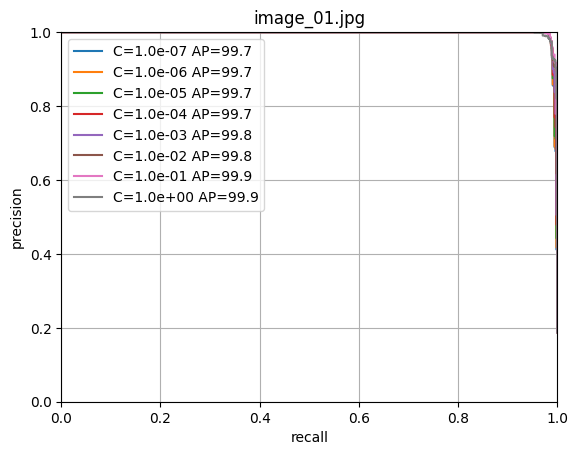

validation using image_02.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


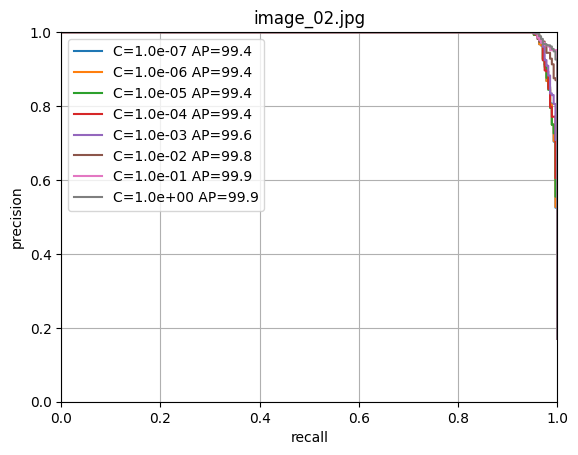

validation using image_03.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


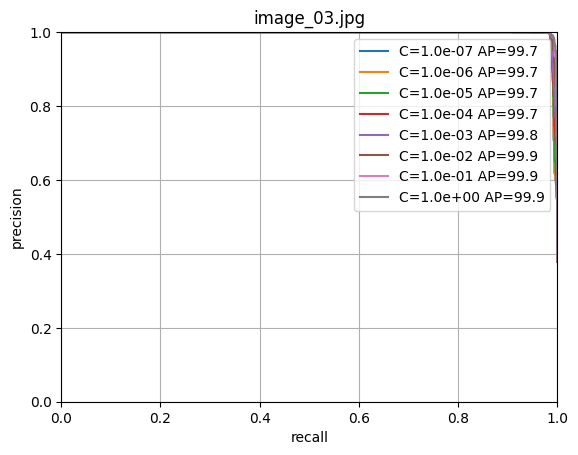

validation using image_04.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


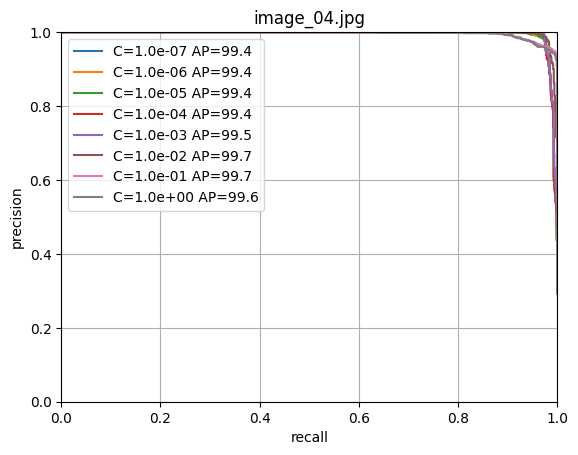

validation using image_05.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


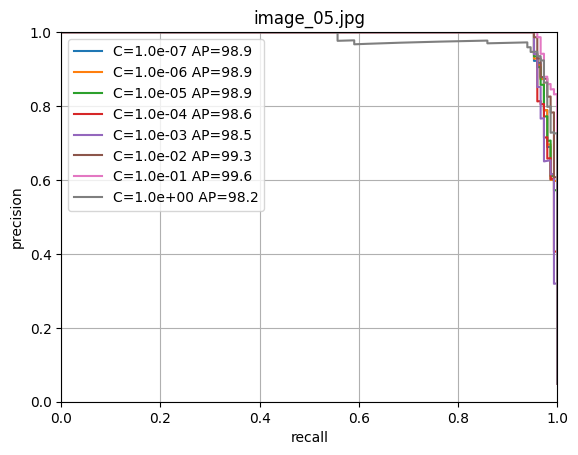

validation using image_06.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


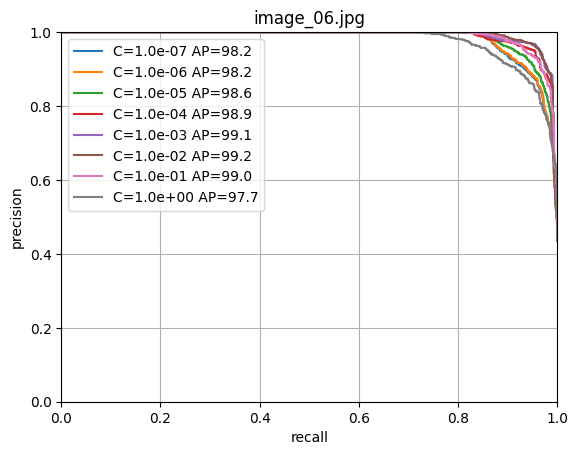

validation using image_07.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


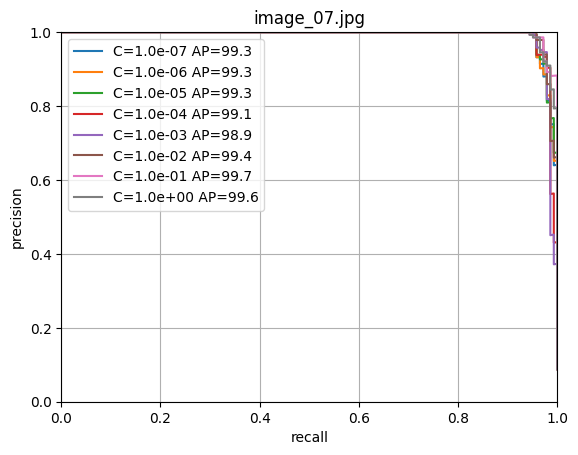

validation using image_08.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


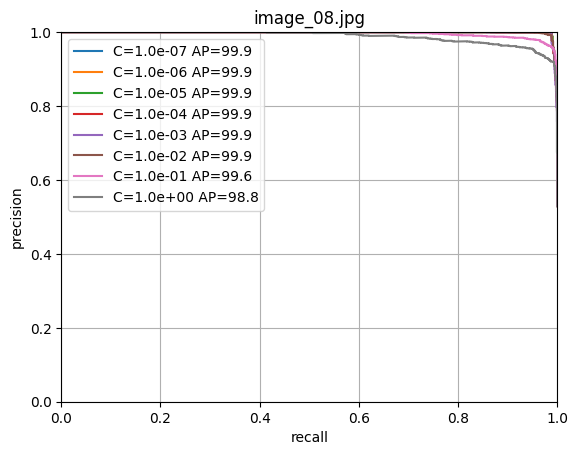

validation using image_09.jpg
training logisitic regression with C=1.00e-07
training logisitic regression with C=1.00e-06
training logisitic regression with C=1.00e-05
training logisitic regression with C=1.00e-04
training logisitic regression with C=1.00e-03
training logisitic regression with C=1.00e-02
training logisitic regression with C=1.00e-01
training logisitic regression with C=1.00e+00


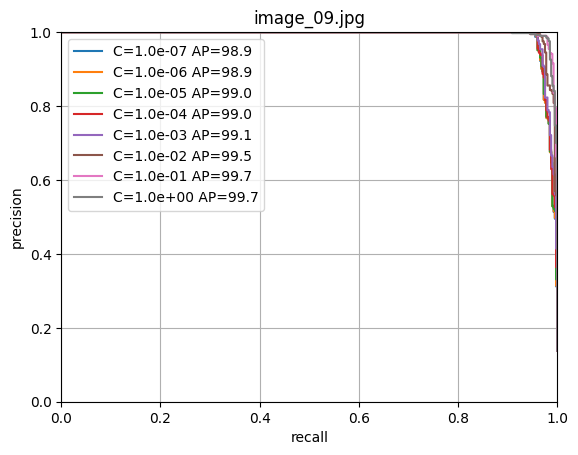

In [10]:
cs = np.logspace(-7, 0, 8)
scores = np.zeros((n_images, len(cs)))

for i in range(n_images):
    # We use leave-one-out so train will be all but image i, val will be image i
    print(f'validation using image_{i+1:02d}.jpg')
    train_selection = image_index != float(i)
    fold_x = xs[train_selection].numpy()
    fold_y = (ys[train_selection] > 0).long().numpy()
    val_x = xs[~train_selection].numpy()
    val_y = (ys[~train_selection] > 0).long().numpy()

    plt.figure()
    for j, c in enumerate(cs):
        print(f"training logisitic regression with C={c:.2e}")
        clf = LogisticRegression(random_state=0, C=c, max_iter=10000).fit(fold_x, fold_y)
        output = clf.predict_proba(val_x)
        precision, recall, thresholds = precision_recall_curve(val_y, output[:, 1])
        s = average_precision_score(val_y, output[:, 1])
        scores[i, j] = s
        plt.plot(recall, precision, label=f'C={c:.1e} AP={s*100:.1f}')

    plt.grid()
    plt.xlabel('recall')
    plt.title(f'image_{i+1:02d}.jpg')
    plt.ylabel('precision')
    plt.axis([0, 1, 0, 1])
    plt.legend()
    plt.show()


### Choosing the Best C
Now, let's have a look at which value of C works best on average. To this end we will plot the average mAP across all validation images.

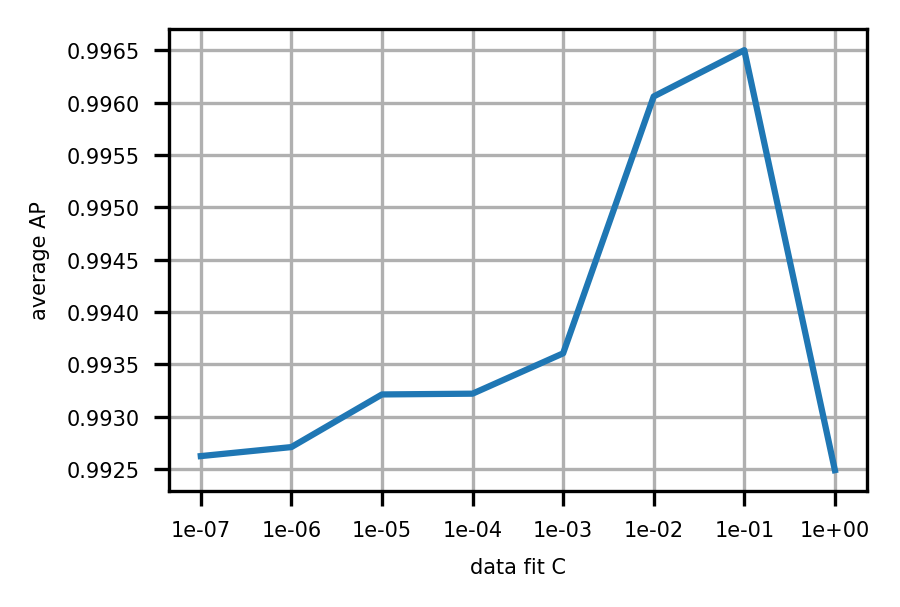

In [11]:
plt.figure(figsize=(3, 2), dpi=300)
plt.rcParams.update({
    "xtick.labelsize": 5,
    "ytick.labelsize": 5,
    "axes.labelsize": 5,
})
plt.plot(scores.mean(axis=0))
plt.xticks(np.arange(len(cs)), [f"{c:.0e}" for c in cs])
plt.xlabel('data fit C')
plt.ylabel('average AP')
plt.grid()
plt.show()

### Retraining with the optimal regularization
Given the above, we seem to have a winner: C=0.1. 
Let's now train a model using this optimal data-fit value. 

In [12]:
clf = LogisticRegression(random_state=0, C=0.1, max_iter=100000, verbose=2).fit(xs.numpy(), (ys > 0).long().numpy())

### Test Images and Inference 

We have a classifier, now it is time to test it! We will predict the probability of patch being foreground given an image, and then process it with a 3x3 median filter to smooth it out.

/var/folders/rc/594kgpld1czfpr55m3_m1szw0000gr/T/ipykernel_23591/3173869696.py:13: UserWarning: CUDA is not available or torch_xla is imported. Disabling autocast.
  with torch.autocast(device_type='cuda', dtype=torch.float32):


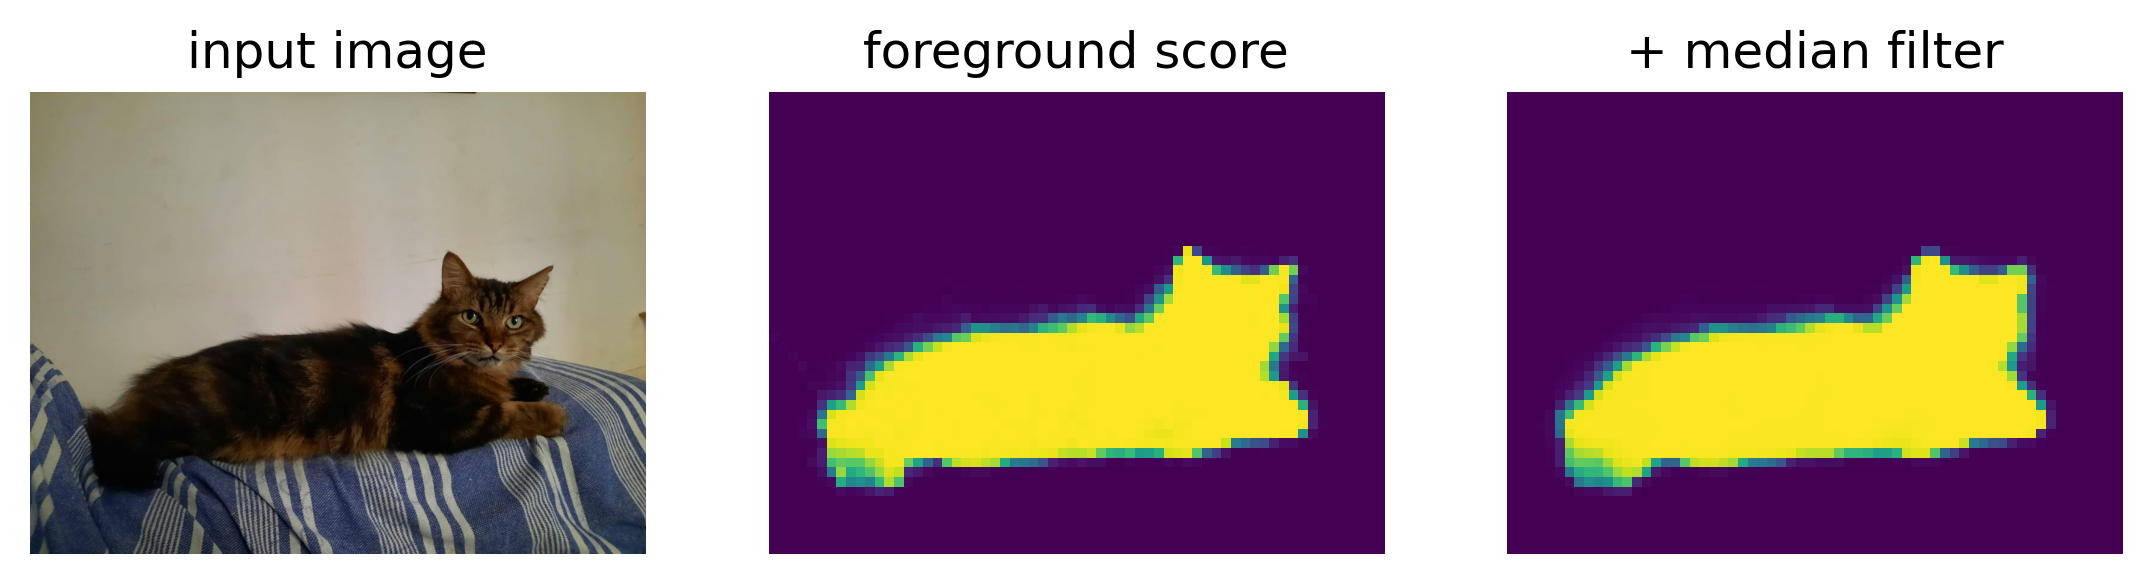

In [13]:
test_image_fpath = "https://dl.fbaipublicfiles.com/dinov3/notebooks/foreground_segmentation/test_image.jpg"

def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")


test_image = load_image_from_url(test_image_fpath)
test_image_resized = resize_transform(test_image)
test_image_normalized = TF.normalize(test_image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)

with torch.inference_mode():
    with torch.autocast(device_type='cuda', dtype=torch.float32):
        feats = model.get_intermediate_layers(test_image_normalized.unsqueeze(0), n=range(n_layers), reshape=True, norm=True)
        x = feats[-1].squeeze().detach().cpu()
        dim = x.shape[0]
        x = x.view(dim, -1).permute(1, 0)

h_patches, w_patches = (int(d / PATCH_SIZE) for d in test_image_resized.shape[1:])

fg_score = clf.predict_proba(x)[:, 1].reshape(h_patches, w_patches)
fg_score_mf = torch.from_numpy(signal.medfilt2d(fg_score, kernel_size=3))

plt.figure(figsize=(9, 3), dpi=300)
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(test_image_resized.permute(1, 2, 0))
plt.title('input image')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(fg_score)
plt.title('foreground score')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(fg_score_mf)
plt.title('+ median filter')
plt.show()

### Saving the Model for Future Use
We are nearly done, let's just save a pickle with the classifier.


In [14]:
save_root = '.'
model_path = os.path.join(save_root, "fg_classifier.pkl")
with open(model_path, "wb") as f:
  pickle.dump(clf, f)